## Broadcast Channel Demo

Author: Cheuk Ting Li  

In [1]:
from psitip import *
PsiOpts.setting(
    solver = "ortools.GLOP",    # Set linear programming solver
    repr_latex = True,          # Jupyter Notebook LaTeX display
    venn_latex = True,          # LaTeX in diagrams
    proof_note_color = "blue",  # Reasons in proofs are blue
    solve_display_reg = True,   # Display claims in solve commands
    random_seed = 4321          # Random seed for example searching
)

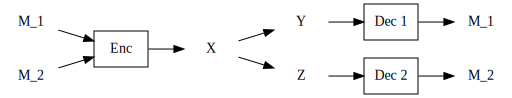

In [2]:
X, Y, Z, U, V = rv("X, Y, Z, U, V")
M1, M2 = rv_array("M", 1, 3)
R1, R2 = real_array("R", 1, 3)

model = CodingModel()     # Define broadcast channel
model.set_rate(M1, R1)    # Rate of M1 is R1
model.set_rate(M2, R2)    # Rate of M2 is R2
model.add_node(M1+M2, X,
          label = "Enc")  # Encoder maps M1,M2 to X
model.add_edge(X, Y)      # Channel X -> Y
model.add_edge(X, Z)      # Channel X -> Z
model.add_node(Y, M1,
        label = "Dec 1")  # Decoder 1 maps Y to M1
model.add_node(Z, M2,
        label = "Dec 2")  # Decoder 2 maps Z to M2

model.graph()             # Draw diagram

In [3]:
# Automatic inner bound, gives 3-auxiliary Marton's inner bound 
#  [Marton 1979], [Gel'fand-Pinsker 1980], [Liang-Kramer 2007]
r = model.get_inner()
r.display(str_proof_note = True)  # Include reasons in blue

<IPython.core.display.Math object>

In [4]:
# Define UV outer bound [El Gamal 1979], [Nair-El Gamal 2006]
U1, U2 = rv_array("U", 1, 3)
r_uv = alland([
    R1 >= 0,
    R2 >= 0,
    R1 <= I(U1 & Y),
    R2 <= I(U2 & Z),
    R1+R2 <= I(U1 & Y) + I(X & Z | U1),
    R1+R2 <= I(U2 & Z) + I(X & Y | U2),
    markov(U1+U2, X, Y+Z),
    markov(Y, X, Z)
]).exists(U1+U2)
r_uv

( ( R_1 >= 0 )
 &( R_2 >= 0 )
 &( R_1 <= I(U_1&Y) )
 &( R_2 <= I(U_2&Z) )
 &( R_1+R_2 <= I(U_1&Y)+I(X&Z|U_1) )
 &( R_1+R_2 <= I(U_2&Z)+I(X&Y|U_2) )
 &( markov(Y, X, Z) )
 &( markov(Y+Z, X, U_1+U_2) ) ).exists(U_1+U_2)

In [5]:
r_out = model.get_outer() # Get outer bound
# Prove UV outer bound and output auxiliaries for proof
(r_out >> r_uv).check_getaux_array()

CompArray(
[[U_1, Y_F+Z_P+M_1],
 [U_2, Y_F+Z_P+M_2]])

In [6]:
# Output proof of UV outer bound (is_proof = True for shorter proof)
(model.get_outer(is_proof = True) >> r_uv).proof()

In [7]:
C = model.maximum(R1 + R2, [R1, R2], name = "C")  # Get sum capacity

In [8]:
# Lower bound C >= max(I(X;Y), I(X;Z))
# model.get_region() gives markov(Y,X,Z), needed since it is an assumption in C
(model.get_region() >> (C >= emax(I(X & Y), I(X & Z)))).display_bool()

<IPython.core.display.Math object>

In [9]:
# Upper bound C <= I(X & Y+Z)
(model.get_region() >> (C <= I(X & Y+Z))).display_bool()

<IPython.core.display.Math object>

### Less Noisy and More Capable

In [10]:
# More capable BC [Körner-Marton 1975], [El Gamal 1979]
mc = (markov(V, X, Y+Z) >> (I(X & Y | V) >= I(X & Z | V))).forall(V)
mc.add_meta("pf_note", ["more capable"]) # Add a note to the proof
model.reg = mc

# For less noisy BC [Körner-Marton 1975], use:
# model.reg = (markov(U+V, X, Y+Z) >> (I(U & Y | V) >= I(U & Z | V))).forall(U+V)

r_mc = model.get_inner() # Give superposition region [Bergmans 1973], [Gallager 1974]
r_mc.display(str_proof_note = True)  # Include reasons in blue

<IPython.core.display.Math object>

In [11]:
# Output proof of tightness (is_proof = True for shorter proof)
(model.get_outer(is_proof = True) >> r_mc).proof()

### Degraded Message Sets

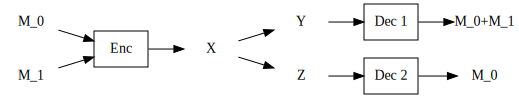

In [12]:
M0, M1 = rv_array("M", 2)
R0, R1 = real_array("R", 2)

model = CodingModel()     # Degraded message set
model.set_rate(M0, R0)    # Rate of M0 is R0
model.set_rate(M1, R1)    # Rate of M1 is R1
model.add_node(M0+M1, X,
          label = "Enc")  # Encoder maps M1,M2 to X
model.add_edge(X, Y)      # Channel X -> Y
model.add_edge(X, Z)      # Channel X -> Z
model.add_node(Y, M0+M1,
        label = "Dec 1")  # Decoder 1 maps Y to M0,M1
model.add_node(Z, M0,
        label = "Dec 2")  # Decoder 2 maps Z to M0

model.graph()             # Draw diagram

In [13]:
r = model.get_inner() # Give superposition region [Bergmans 1973], [Gallager 1974]
r.display(str_proof_note = True)  # Include reasons in blue

<IPython.core.display.Math object>

In [14]:
r_out = model.get_outer()         # Get outer bound
(r_out >> r).check_getaux_array() # Check tightness

CompArray(
[[A_M_0, Y_F+Z_P+M_0]])

In [15]:
# Output converse proof (is_proof = True for shorter proof)
(model.get_outer(is_proof = True) >> r).proof()

### References
- A. El Gamal and Y.-H. Kim, _Network Information Theory_, Cambridge University Press, 2011, Ch. 5, 8.
-  K. Marton, "A coding theorem for the discrete memoryless broadcast channel," IEEE Transactions on Information Theory, vol. 25, no. 3, pp. 306–311, May 1979.
- S. I. Gel'fand and M. S. Pinsker, "Capacity of a broadcast channel with one deterministic component," Problemy Peredachi Informatsii, vol. 16, no. 1, pp. 24–34, 1980.
- Y. Liang and G. Kramer, "Rate regions for relay broadcast channels," IEEE Transactions on Information Theory, vol. 53, no. 10, pp. 3517–3535, Oct 2007.
- C. Nair and A. El Gamal, "An outer bound to the capacity region of the broadcast channel," IEEE Transactions on Information Theory, vol. 53, no. 1, pp. 350–355, 2006.
- J. Körner and K. Marton, "Comparison of two noisy channels," Topics in information theory, pp. 411–423, 1977.
- A. El Gamal, "The capacity of a class of broadcast channels," IEEE Transactions on Information Theory, vol. 25, no. 2, pp. 166–169, 1979.
- P. Bergmans, "Random coding theorem for broadcast channels with degraded components," IEEE Transactions on Information Theory, vol. 19, no. 2, pp. 197–207, 1973.
- R. G. Gallager, "Capacity and coding for degraded broadcast channels," Problemy Peredachi Informatsii, vol. 10, no. 3, pp. 3–14, 1974.